In [5]:
import medmnist
from medmnist import OCTMNIST
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import ConcatDataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from PIL import Image

In [6]:
train_set = OCTMNIST(split='train', download=True)
val_set   = OCTMNIST(split='val', download=True)
test_set  = OCTMNIST(split='test', download=True)

full_dataset = ConcatDataset([train_set, val_set, test_set])

100%|██████████| 54.9M/54.9M [00:05<00:00, 10.9MB/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [7]:
images = [np.array(full_dataset[i][0]) for i in range(len(full_dataset))]
labels = [full_dataset[i][1] for i in range(len(full_dataset))]
images = np.array(images)
labels = np.array(labels)

print("Dataset Statistics:")
print(f"Total samples: {len(labels)}")
unique_labels, counts = np.unique(labels, return_counts=True)
for lbl, cnt in zip(unique_labels, counts):
    print(f"Class {lbl}: {cnt} samples ({cnt/len(labels)*100:.2f}%)")

Dataset Statistics:
Total samples: 109309
Class 0: 37455 samples (34.27%)
Class 1: 11598 samples (10.61%)
Class 2: 8866 samples (8.11%)
Class 3: 51390 samples (47.01%)


In [8]:
mean_pixel = np.mean(images)
std_pixel = np.std(images)
print(f"Mean Pixel Intensity: {mean_pixel:.4f}")
print(f"Standard Deviation of Pixel Intensity: {std_pixel:.4f}")
print(f"Any missing values? {np.isnan(images).any()}")

Mean Pixel Intensity: 48.2002
Standard Deviation of Pixel Intensity: 50.0744
Any missing values? False


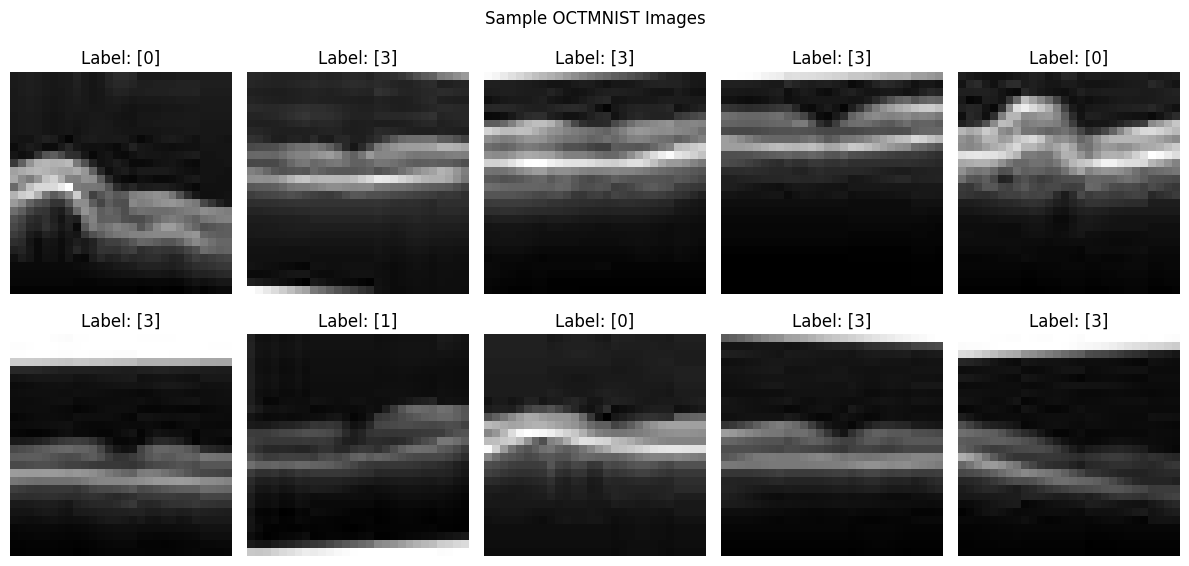

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
plt.suptitle("Sample OCTMNIST Images")
plt.tight_layout()
plt.show()


/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_62476/2052645457.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette="viridis")


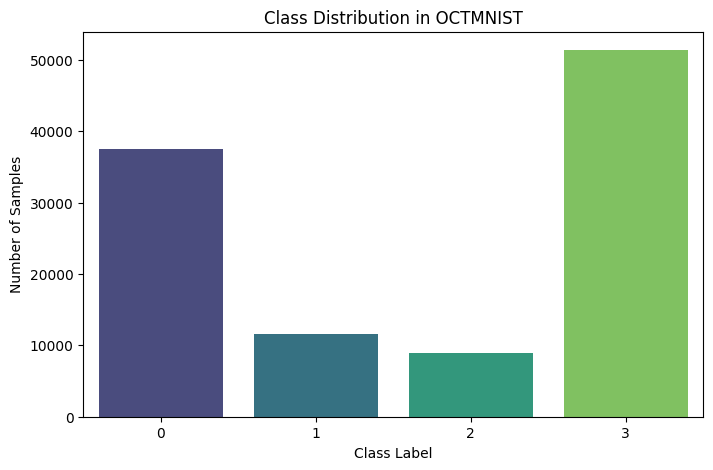

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=unique_labels, y=counts, palette="viridis")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in OCTMNIST")
plt.show()

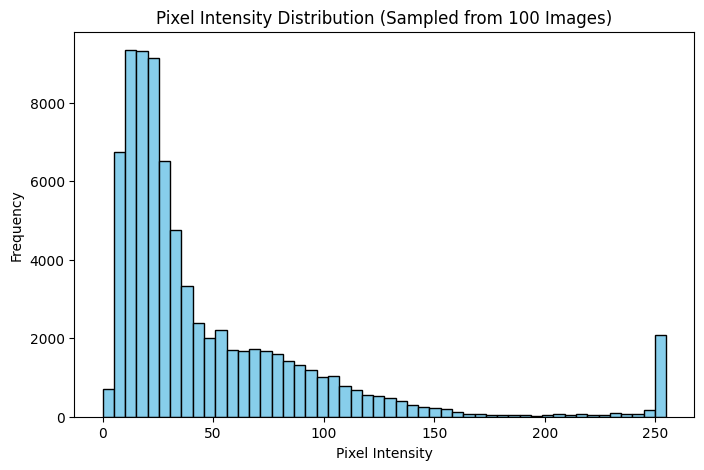

In [ ]:
random_idx = np.random.choice(len(images), size=100, replace=False)
sample_pixels = np.concatenate([images[i].flatten() for i in random_idx])
plt.figure(figsize=(8, 5))
plt.hist(sample_pixels, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution (Sampled from 100 Images)")
plt.show()


In [ ]:
#Normalizing Pixel Values
images_norm = images.astype(np.float32) / 255.0
images_norm = images_norm[:, np.newaxis, :, :]

In [ ]:
# Balancing the Dataset using a Pipeline of Oversampling and Undersampling
N, C, H, W = images_norm.shape
images_flat = images_norm.reshape(N, -1)

over = SMOTE(sampling_strategy='auto', random_state=42)  # oversample minority classes
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)  # undersample majority class

pipeline = Pipeline(steps=[('o', over), ('u', under)])
images_bal_flat, labels_bal = pipeline.fit_resample(images_flat, labels)
images_bal = images_bal_flat.reshape(-1, 1, H, W)

print("\nAfter Combined Oversampling & Undersampling:")
unique_labels_bal, counts_bal = np.unique(labels_bal, return_counts=True)
for lbl, cnt in zip(unique_labels_bal, counts_bal):
    print(f"Class {lbl}: {cnt} samples ({cnt/len(labels_bal)*100:.2f}%)")


After Combined Oversampling & Undersampling:
Class 0: 51390 samples (25.00%)
Class 1: 51390 samples (25.00%)
Class 2: 51390 samples (25.00%)
Class 3: 51390 samples (25.00%)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images_bal, labels_bal, test_size=0.4, stratify=labels_bal, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("\nDataset Split:")
print("Training set shape:", X_train.shape, "Labels shape:", y_train.shape)
print("Validation set shape:", X_val.shape, "Labels shape:", y_val.shape)
print("Test set shape:", X_test.shape, "Labels shape:", y_test.shape)


Dataset Split:
Training set shape: (123336, 1, 28, 28) Labels shape: (123336,)
Validation set shape: (41112, 1, 28, 28) Labels shape: (41112,)
Test set shape: (41112, 1, 28, 28) Labels shape: (41112,)


In [ ]:
train_counts = Counter(y_train)
mean_count = np.mean(list(train_counts.values()))
minority_classes = [cls for cls, cnt in train_counts.items() if cnt < mean_count]
print("\nMinority classes in training set:", minority_classes)

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

def augment_minority_samples(X, y, minority_classes, n_aug=2):
    """
    For each training sample belonging to a minority class,
    apply the augmentation transformation n_aug times.
    """
    X_aug_list = []
    y_aug_list = []
    for i in range(len(X)):
        if y[i] in minority_classes:
            img = X[i].squeeze(0)
            img_uint8 = (img * 255).astype(np.uint8)
            pil_img = Image.fromarray(img_uint8)
            for _ in range(n_aug):
                aug_img = augmentation_transform(pil_img)
                aug_img_np = np.array(aug_img).astype(np.float32) / 255.0
                if len(aug_img_np.shape) == 2:
                    aug_img_np = np.expand_dims(aug_img_np, axis=0)
                else:
                    aug_img_np = np.expand_dims(np.mean(aug_img_np, axis=2), axis=0)
                X_aug_list.append(aug_img_np)
                y_aug_list.append(y[i])
    if X_aug_list:
        X_augmented = np.stack(X_aug_list, axis=0)
        y_augmented = np.array(y_aug_list)
        return X_augmented, y_augmented
    else:
        return np.empty((0, 1, H, W)), np.array([])

X_train_aug, y_train_aug = augment_minority_samples(X_train, y_train, minority_classes, n_aug=2)
print("Number of augmented minority samples:", X_train_aug.shape[0])

X_train_combined = np.concatenate([X_train, X_train_aug], axis=0)
y_train_combined = np.concatenate([y_train, y_train_aug], axis=0)
print("Combined training set shape:", X_train_combined.shape)


Minority classes in training set: []
Number of augmented minority samples: 0
Combined training set shape: (123336, 1, 28, 28)


In [ ]:
train_counts_comb = Counter(y_train_combined)
total_train = len(y_train_combined)
num_classes = len(train_counts_comb)
class_weights = {cls: total_train / (num_classes * cnt) for cls, cnt in train_counts_comb.items()}

print("\nClass Weights (for loss function):")
for cls in sorted(class_weights.keys()):
    print(f"Class {cls}: {class_weights[cls]:.4f}")


Class Weights (for loss function):
Class 0.0: 1.0000
Class 1.0: 1.0000
Class 2.0: 1.0000
Class 3.0: 1.0000


In [ ]:
weights_tensor = torch.tensor([class_weights[c] for c in sorted(class_weights.keys())], dtype=torch.float32)
print("Weights tensor:", weights_tensor)

Weights tensor: tensor([1., 1., 1., 1.])


In [ ]:
batch_size = 64

train_dataset = TensorDataset(torch.tensor(X_train_combined, dtype=torch.float32),
                              torch.tensor(y_train_combined, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.dropout(x)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        return x

model = SimpleCNN()

print("Model Summary:")
summary(model, input_size=(1, 1, 28, 28))

Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Dropout: 1-5                           [1, 3136]                 --
├─Linear: 1-6                            [1, 128]                  401,536
├─Linear: 1-7                            [1, 4]                    516
Total params: 420,868
Trainable params: 420,868
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.68
Estimated Total Size (MB): 1.99

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 20
best_val_accuracy = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total_train
    epoch_train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            loss_val = loss_function(val_outputs, val_labels)
            running_val_loss += loss_val.item() * val_inputs.size(0)

            _, predicted_val = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    epoch_val_loss = running_val_loss / total_val
    epoch_val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), "best_model.pth")

end_time = time.time()
print(f"Training complete in {(end_time - start_time):.0f} seconds")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch [1/20]: Train Loss: 0.8892, Train Acc: 0.6291 | Val Loss: 0.6189, Val Acc: 0.7607
Epoch [2/20]: Train Loss: 0.6390, Train Acc: 0.7501 | Val Loss: 0.5686, Val Acc: 0.7743
Epoch [3/20]: Train Loss: 0.5495, Train Acc: 0.7873 | Val Loss: 0.4569, Val Acc: 0.8300
Epoch [4/20]: Train Loss: 0.5064, Train Acc: 0.8045 | Val Loss: 0.4100, Val Acc: 0.8469
Epoch [5/20]: Train Loss: 0.4673, Train Acc: 0.8207 | Val Loss: 0.3829, Val Acc: 0.8568
Epoch [6/20]: Train Loss: 0.4443, Train Acc: 0.8289 | Val Loss: 0.3656, Val Acc: 0.8648
Epoch [7/20]: Train Loss: 0.4248, Train Acc: 0.8382 | Val Loss: 0.3488, Val Acc: 0.8706
Epoch [8/20]: Train Loss: 0.4061, Train Acc: 0.8451 | Val Loss: 0.3259, Val Acc: 0.8781
Epoch [9/20]: Train Loss: 0.3910, Train Acc: 0.8513 | Val Loss: 0.3246, Val Acc: 0.8815
Epoch [10/20]: Train Loss: 0.3779, Train Acc: 0.8559 | Val Loss: 0.3134, Val Acc: 0.8842
Epoch [11/20]: Train Loss: 0.3676, Train Acc: 0.8599 | Val Loss: 0.2991, Val Acc: 0.8904
Epoch [12/20]: Train Loss: 0.3

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss_total = 0.0
test_total = 0

all_preds = []
all_true = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)

        loss_value = loss_function(test_outputs, test_labels)
        test_loss_total += loss_value.item() * test_inputs.size(0)
        test_total += test_inputs.size(0)

        _, predicted = torch.max(test_outputs, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(test_labels.cpu().numpy())

print("Number of test samples (all_true):", len(all_true))
print("Number of predicted samples (all_preds):", len(all_preds))

test_accuracy = accuracy_score(all_true, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='weighted')
test_loss = test_loss_total / test_total

print("\nTest Performance:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Number of test samples (all_true): 41112
Number of predicted samples (all_preds): 41112

Test Performance:
Test Accuracy: 0.9152
Precision: 0.9154
Recall:    0.9152
F1 Score:  0.9152
Test Loss: 0.2432


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from itertools import cycle
import torch

In [ ]:
epochs = np.arange(1, num_epochs + 1)

test_accuracy_line = [test_accuracy] * num_epochs
test_loss_line = [test_loss] * num_epochs


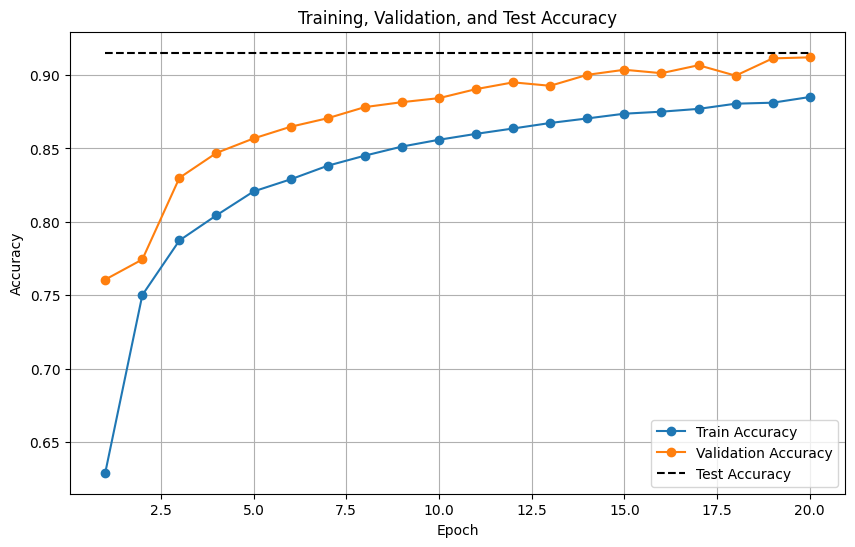

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(epochs, test_accuracy_line, label='Test Accuracy', linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

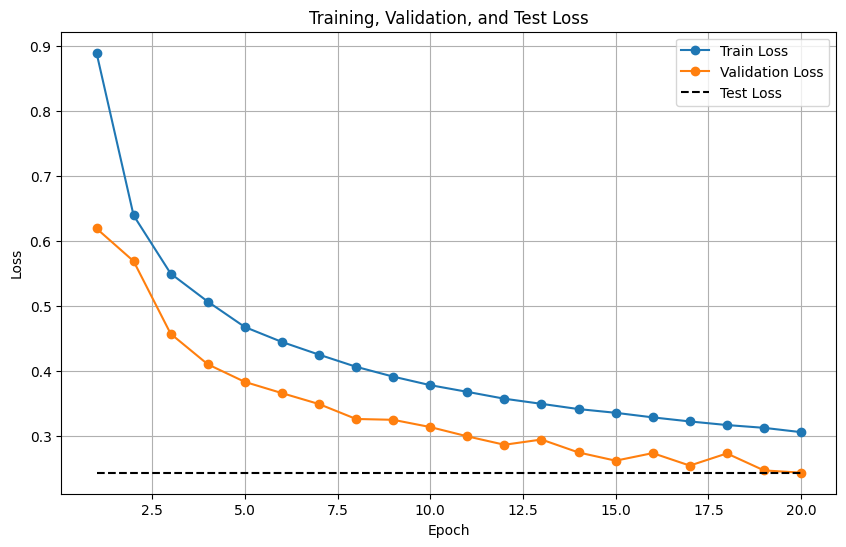

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, test_loss_line, label='Test Loss', linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

Number of test samples (all_true): 41112
Number of predicted samples (all_preds): 41112


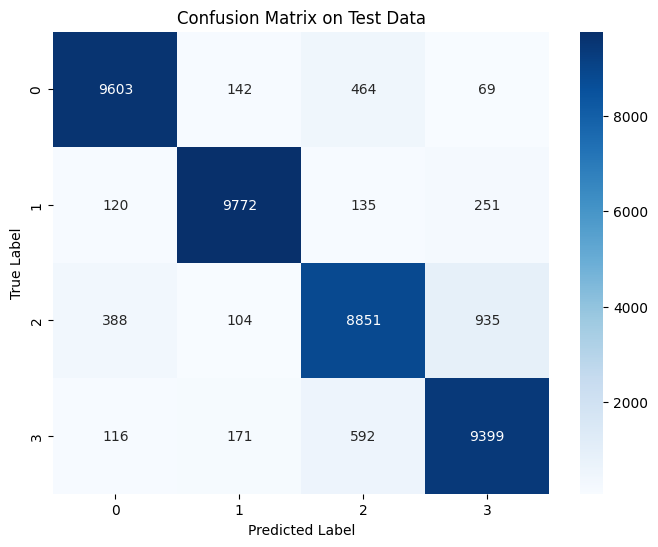

In [ ]:
print("Number of test samples (all_true):", len(all_true))
print("Number of predicted samples (all_preds):", len(all_preds))

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.show()

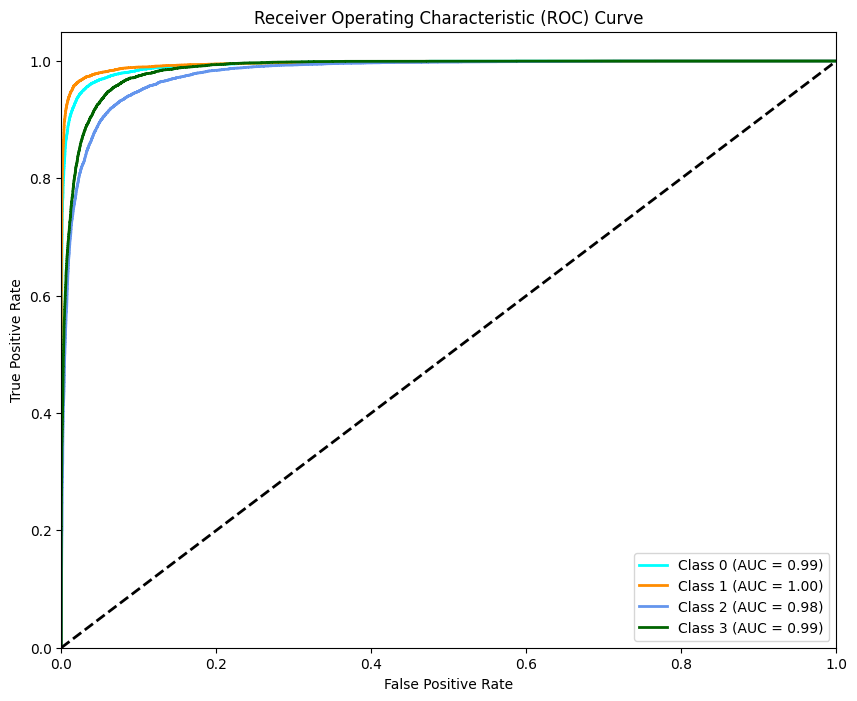

In [ ]:
model.eval()
all_probs = []
all_true_probs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        outputs = model(test_inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_true_probs.append(test_labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_true_probs = np.concatenate(all_true_probs, axis=0)

n_classes = all_probs.shape[1]
all_true_bin = label_binarize(all_true_probs, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(all_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
class FocalLoss(nn.Module):
    """
    Focal Loss for multi-class classification.
    """
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, input, target):
        logpt = -self.ce_loss(input, target)
        pt = torch.exp(logpt)
        loss = -((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14x14 -> 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

print("SimpleCNN Summary:")
summary(SimpleCNN(), input_size=(1, 1, 28, 28))

SimpleCNN Summary:


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Dropout: 1-5                           [1, 3136]                 --
├─Linear: 1-6                            [1, 128]                  401,536
├─Linear: 1-7                            [1, 4]                    516
Total params: 420,868
Trainable params: 420,868
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.68
Estimated Total Size (MB): 1.99

In [ ]:
print("\nImprovedCNN Summary:")
summary(ImprovedCNN(), input_size=(1, 1, 28, 28))


ImprovedCNN Summary:


Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNN                              [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Dropout: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 128]                  401,536
├─BatchNorm1d: 1-9                       [1, 128]                  256
├─Linear: 1-10                           [1, 4]                    516
Total params: 421,316
Trainable params: 421,316
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/

In [ ]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs, train_loader, val_loader, model_label="Model", early_stopping_patience=5):
    """
    Trains the model and returns history metrics.
    Implements early stopping based on validation accuracy.
    """
    model = model.to(device)
    best_val_accuracy = 0.0
    best_model_state = None
    epochs_no_improve = 0

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                loss_val = loss_fn(val_outputs, val_labels)
                running_val_loss += loss_val.item() * val_inputs.size(0)
                _, predicted_val = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()
        val_loss = running_val_loss / total_val
        val_acc = correct_val / total_val

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{model_label} Epoch [{epoch+1}/{num_epochs}]: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if scheduler is not None:
            scheduler.step(val_loss)

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, history, best_val_accuracy


In [ ]:
def evaluate_model(model, loss_fn, test_loader):
    model.eval()
    test_loss_total = 0.0
    test_total = 0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            test_outputs = model(test_inputs)
            loss_value = loss_fn(test_outputs, test_labels)
            test_loss_total += loss_value.item() * test_inputs.size(0)
            test_total += test_inputs.size(0)
            _, predicted = torch.max(test_outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(test_labels.cpu().numpy())
    test_loss = test_loss_total / test_total
    test_accuracy = accuracy_score(all_true, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_preds, average='weighted')
    return test_loss, test_accuracy, precision, recall, f1, all_true, all_preds


In [ ]:
num_epochs = 20

base_model = SimpleCNN().to(device)
ce_loss_fn = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(base_model.parameters(), lr=0.001)
scheduler_base = optim.lr_scheduler.ReduceLROnPlateau(optimizer_base, mode='min', factor=0.5, patience=3, verbose=True)

print("\nTraining Base Model (SimpleCNN with CrossEntropyLoss)")
base_model, base_history, base_best_val_acc = train_model(
    base_model, ce_loss_fn, optimizer_base, scheduler_base,
    num_epochs, train_loader, val_loader, model_label="Base Model", early_stopping_patience=5
)

base_test_loss, base_test_acc, base_precision, base_recall, base_f1, base_true, base_preds = evaluate_model(base_model, ce_loss_fn, test_loader)
print("\nBase Model Test Performance:")
print(f"Test Loss: {base_test_loss:.4f}, Test Accuracy: {base_test_acc:.4f}")
print(f"Precision: {base_precision:.4f}, Recall: {base_recall:.4f}, F1 Score: {base_f1:.4f}")



Training Base Model (SimpleCNN with CrossEntropyLoss)
Base Model Epoch [1/20]: Train Loss: 0.8429, Train Acc: 0.6493 | Val Loss: 0.6019, Val Acc: 0.7690
Base Model Epoch [2/20]: Train Loss: 0.6157, Train Acc: 0.7588 | Val Loss: 0.5132, Val Acc: 0.8014
Base Model Epoch [3/20]: Train Loss: 0.5414, Train Acc: 0.7898 | Val Loss: 0.4517, Val Acc: 0.8343
Base Model Epoch [4/20]: Train Loss: 0.4955, Train Acc: 0.8087 | Val Loss: 0.4445, Val Acc: 0.8285
Base Model Epoch [5/20]: Train Loss: 0.4573, Train Acc: 0.8238 | Val Loss: 0.3874, Val Acc: 0.8537
Base Model Epoch [6/20]: Train Loss: 0.4336, Train Acc: 0.8333 | Val Loss: 0.3590, Val Acc: 0.8663
Base Model Epoch [7/20]: Train Loss: 0.4117, Train Acc: 0.8429 | Val Loss: 0.3765, Val Acc: 0.8551
Base Model Epoch [8/20]: Train Loss: 0.3893, Train Acc: 0.8511 | Val Loss: 0.3259, Val Acc: 0.8794
Base Model Epoch [9/20]: Train Loss: 0.3732, Train Acc: 0.8588 | Val Loss: 0.3045, Val Acc: 0.8870
Base Model Epoch [10/20]: Train Loss: 0.3581, Train Ac

In [ ]:
improved_model = ImprovedCNN().to(device)
focal_loss_fn = FocalLoss(gamma=2)
optimizer_improved = optim.Adam(improved_model.parameters(), lr=0.001)
scheduler_improved = optim.lr_scheduler.ReduceLROnPlateau(optimizer_improved, mode='min', factor=0.5, patience=3, verbose=True)

print("\nTraining Improved Model (ImprovedCNN with FocalLoss)")
improved_model, improved_history, improved_best_val_acc = train_model(
    improved_model, focal_loss_fn, optimizer_improved, scheduler_improved,
    num_epochs, train_loader, val_loader, model_label="Improved Model", early_stopping_patience=5
)

improved_test_loss, improved_test_acc, improved_precision, improved_recall, improved_f1, improved_true, improved_preds = evaluate_model(improved_model, focal_loss_fn, test_loader)
print("\nImproved Model Test Performance:")
print(f"Test Loss: {improved_test_loss:.4f}, Test Accuracy: {improved_test_acc:.4f}")
print(f"Precision: {improved_precision:.4f}, Recall: {improved_recall:.4f}, F1 Score: {improved_f1:.4f}")



Training Improved Model (ImprovedCNN with FocalLoss)


/Users/sruthisriv/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Improved Model Epoch [1/20]: Train Loss: 0.2980, Train Acc: 0.7374 | Val Loss: 0.2244, Val Acc: 0.7961
Improved Model Epoch [2/20]: Train Loss: 0.2076, Train Acc: 0.8053 | Val Loss: 0.1741, Val Acc: 0.8296
Improved Model Epoch [3/20]: Train Loss: 0.1783, Train Acc: 0.8297 | Val Loss: 0.2062, Val Acc: 0.8129
Improved Model Epoch [4/20]: Train Loss: 0.1587, Train Acc: 0.8461 | Val Loss: 0.1530, Val Acc: 0.8515
Improved Model Epoch [5/20]: Train Loss: 0.1432, Train Acc: 0.8587 | Val Loss: 0.1124, Val Acc: 0.8877
Improved Model Epoch [6/20]: Train Loss: 0.1306, Train Acc: 0.8692 | Val Loss: 0.1044, Val Acc: 0.8964
Improved Model Epoch [7/20]: Train Loss: 0.1230, Train Acc: 0.8757 | Val Loss: 0.1098, Val Acc: 0.8962
Improved Model Epoch [8/20]: Train Loss: 0.1145, Train Acc: 0.8837 | Val Loss: 0.0991, Val Acc: 0.8952
Improved Model Epoch [9/20]: Train Loss: 0.1072, Train Acc: 0.8894 | Val Loss: 0.1070, Val Acc: 0.8870
Improved Model Epoch [10/20]: Train Loss: 0.1018, Train Acc: 0.8949 | Val

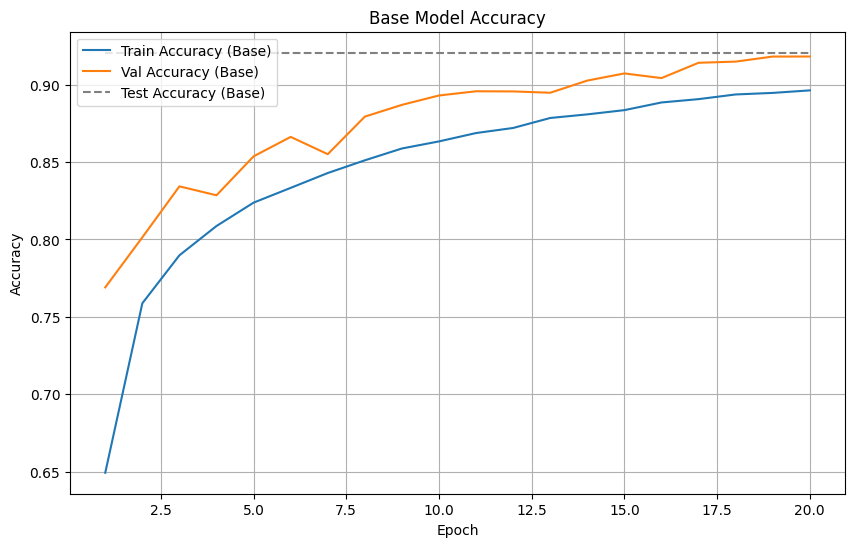

In [ ]:
epochs_range_base = np.arange(1, len(base_history["train_acc"]) + 1)
epochs_range_improved = np.arange(1, len(improved_history["train_acc"]) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs_range_base, base_history["train_acc"], label="Train Accuracy (Base)")
plt.plot(epochs_range_base, base_history["val_acc"], label="Val Accuracy (Base)")
plt.hlines(base_test_acc, xmin=1, xmax=epochs_range_base[-1], colors="gray", linestyles="--", label="Test Accuracy (Base)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Base Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()

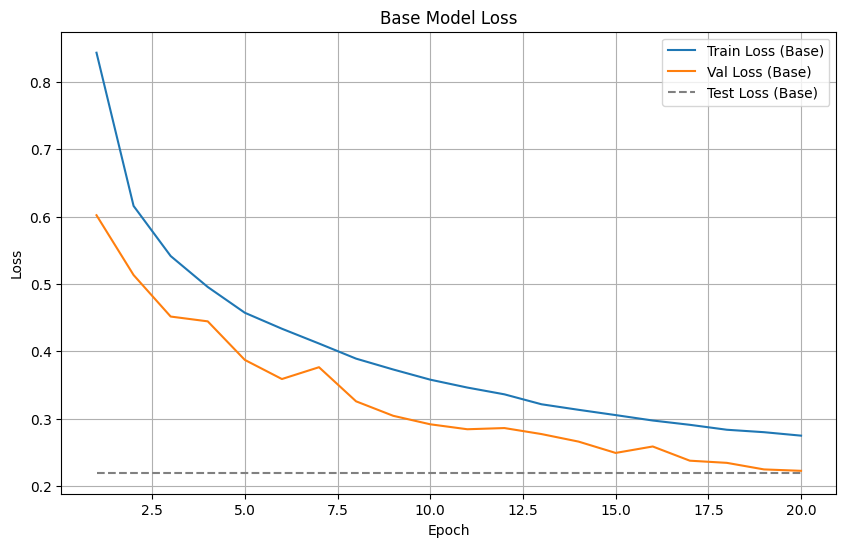

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs_range_base, base_history["train_loss"], label="Train Loss (Base)")
plt.plot(epochs_range_base, base_history["val_loss"], label="Val Loss (Base)")
plt.hlines(base_test_loss, xmin=1, xmax=epochs_range_base[-1], colors="gray", linestyles="--", label="Test Loss (Base)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Base Model Loss")
plt.legend()
plt.grid(True)
plt.show()

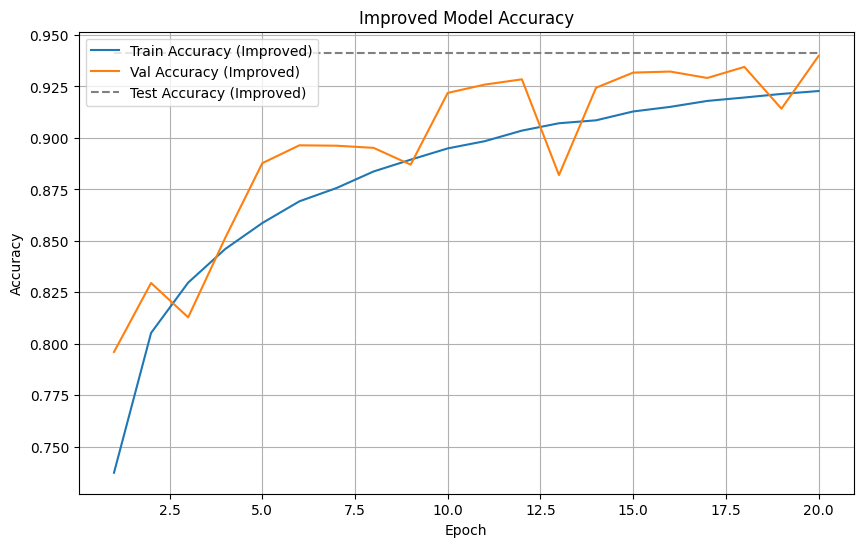

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs_range_improved, improved_history["train_acc"], label="Train Accuracy (Improved)")
plt.plot(epochs_range_improved, improved_history["val_acc"], label="Val Accuracy (Improved)")
plt.hlines(improved_test_acc, xmin=1, xmax=epochs_range_improved[-1], colors="gray", linestyles="--", label="Test Accuracy (Improved)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Improved Model Accuracy")
plt.legend()
plt.grid(True)
plt.show()

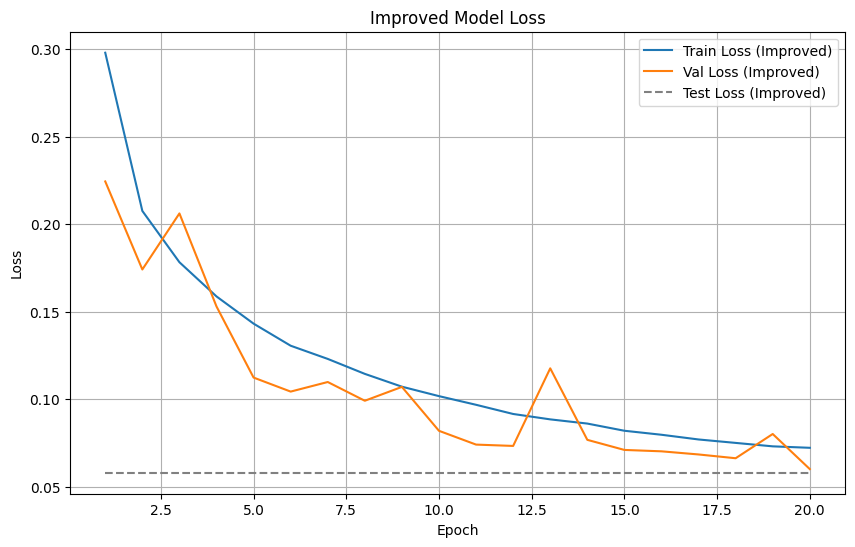

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs_range_improved, improved_history["train_loss"], label="Train Loss (Improved)")
plt.plot(epochs_range_improved, improved_history["val_loss"], label="Val Loss (Improved)")
plt.hlines(improved_test_loss, xmin=1, xmax=epochs_range_improved[-1], colors="gray", linestyles="--", label="Test Loss (Improved)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Improved Model Loss")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/tp/5cysq2jx05n1mjwvqdsgt_v00000gn/T/ipykernel_62476/3216717080.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=test_accuracies, palette="viridis")


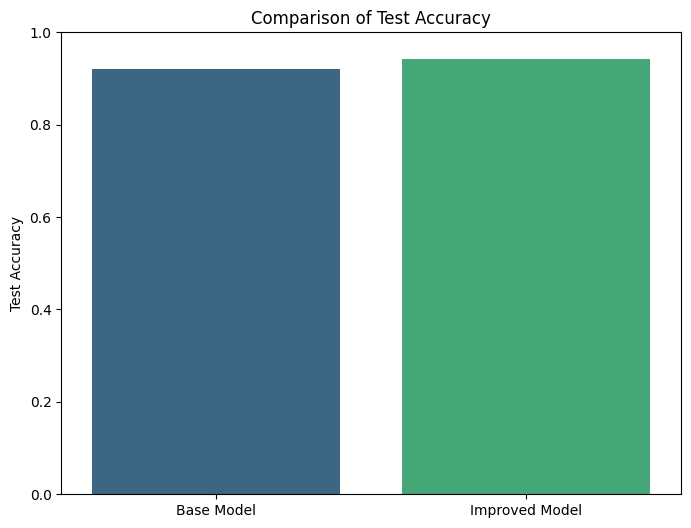

In [ ]:
plt.figure(figsize=(8,6))
models = ['Base Model', 'Improved Model']
test_accuracies = [base_test_acc, improved_test_acc]
sns.barplot(x=models, y=test_accuracies, palette="viridis")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy")
plt.ylim(0, 1)
plt.show()

In [ ]:
if improved_test_acc > base_test_acc:
    best_model = improved_model
    best_model_label = "Improved Model"
    best_loss_fn = focal_loss_fn
else:
    best_model = base_model
    best_model_label = "Base Model"
    best_loss_fn = ce_loss_fn
torch.save(best_model.state_dict(), "best_model_final.pth")
print(f"Best model ({best_model_label}) weights saved as 'best_model_final.pth'.")

Best model (Improved Model) weights saved as 'best_model_final.pth'.


In [ ]:
test_loss, test_acc, precision, recall, f1, test_true, test_preds = evaluate_model(best_model, best_loss_fn, test_loader)

print("\nBest Model Test Performance:")
print(f"Model: {best_model_label}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")


Best Model Test Performance:
Model: Improved Model
Test Loss:     0.0580
Test Accuracy: 0.9414
Precision:     0.9434
Recall:        0.9414
F1 Score:      0.9417


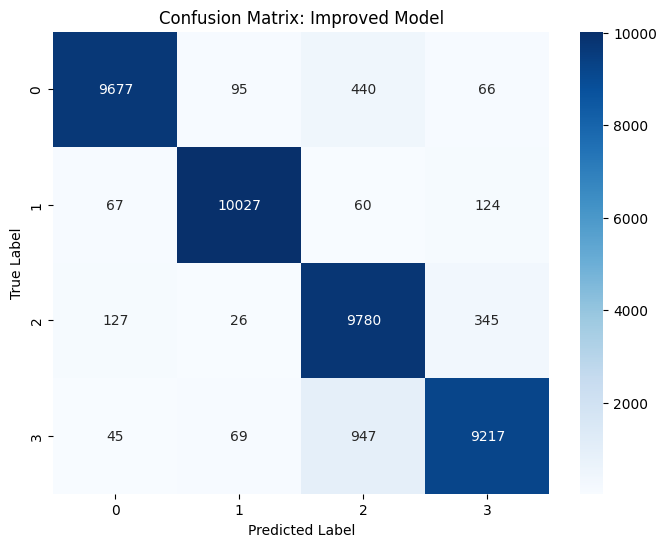

In [ ]:
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: {best_model_label}')
plt.show()

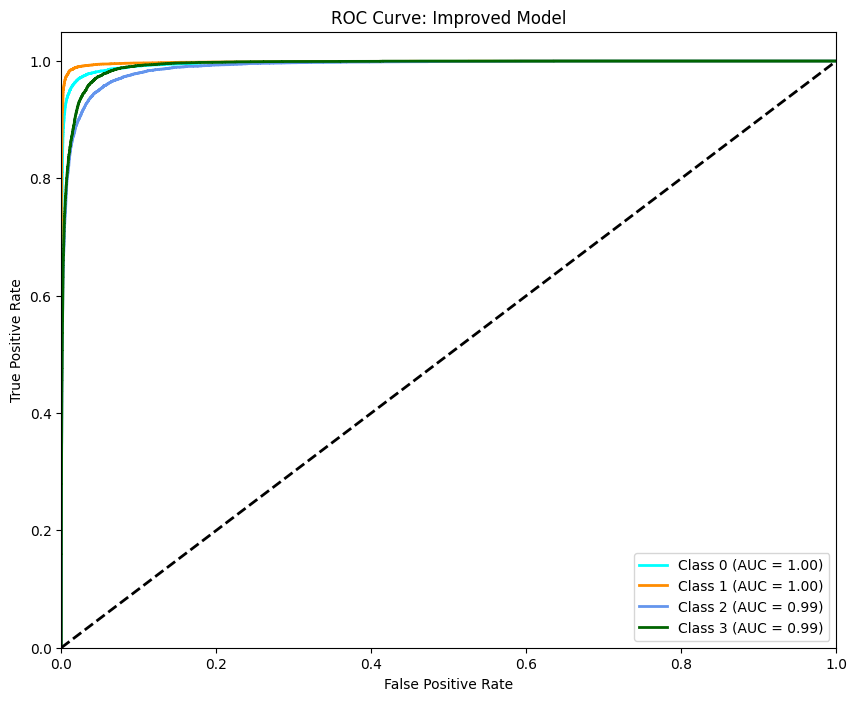

In [ ]:
best_model.eval()
all_probs = []
all_true_probs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        outputs = best_model(test_inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_true_probs.append(test_labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_true_probs = np.concatenate(all_true_probs, axis=0)

n_classes = all_probs.shape[1]  # e.g., 4 classes
all_true_bin = label_binarize(all_true_probs, classes=np.arange(n_classes))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(all_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: {best_model_label}')
plt.legend(loc="lower right")
plt.show()
